# **Installing PyCaret 2.0**

### Mounting the Google Drive

### Importing pycaret seperately

In [2]:
from pycaret.regression import *

# **Imports**

In [3]:
# importing the required libraries
import pandas as pd
import numpy as np
# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

# **Data Preprocessing**

[Dataset Source Link](https://www.kaggle.com/zusmani/pakistan-corona-virus-citywise-data)

In [4]:
# Reading a .csv file by creating a dataframe using pandas
# Reading the datasets
df= pd.read_csv('/home/thom/Downloads/archive/PK COVID-19.csv', parse_dates=["Date"],skipfooter=2)
dt = df.copy()
dt.head()

,Date,Cases,Deaths,Recovered,Travel_history,Province,City
0,2020-02-26,1.0,0.0,0.0,China,Islamabad Capital Territory,Islamabad
1,2020-02-26,2.0,0.0,0.0,Iran/Taftan,Sindh,Karachi
2,2020-02-29,1.0,0.0,0.0,China,Islamabad Capital Territory,Islamabad
3,2020-02-29,1.0,0.0,0.0,Iran/Taftan,Sindh,Karachi
4,2020-03-02,1.0,0.0,0.0,Iran/Taftan,Gilgit-Baltistan,Gilgit


Travel history has less records, we will fill NAs with Unknown

In [5]:
dt['Travel_history'].unique
dt['Travel_history'].fillna('Unknown',  inplace=True)

Type casting variables and fixing one Province value

In [6]:
dt = dt.sort_values('Date')
#dt['Deaths'] = dt['Deaths'].astype(np.integer)
#dt['Cases']=dt['Cases'].astype(np.int)
#dt['Recovered']=dt['Recovered'].astype(np.int)

dt.loc[dt.Province == "khyber Pakhtunkhwa", "Province"] = "Khyber Pakhtunkhwa"
dt.loc[dt.Travel_history == "Tableegi Jamaat", "Travel_history"] = "Tableeghi Jamaat"

Few new features extracted

In [29]:
pdc = dt.groupby('Date')['Cases'].sum().reset_index()
pdd = dt.groupby('Date')['Deaths'].sum().reset_index()#.drop('Date', axis=1)
pdr = dt.groupby('Date')['Recovered'].sum().reset_index()#.reset_index()#.drop('Date', axis=1)

p = pd.DataFrame(pdc) 
p['Deaths'] = pdd['Deaths']
p['Recovered'] = pdr['Recovered']

#Cumulative Sum
p['Cum_Cases'] = p['Cases'].cumsum() 
p['Cum_Cases_next'] = p['Cum_Cases'].shift(-1)
p['Cum_Deaths'] = p['Deaths'].cumsum()
p['Cum_Recovered'] = p['Recovered'].cumsum()

del pdc, pdd, pdr 
p.head()

,Date,Cases,Deaths,Recovered,Cum_Cases,Cum_Cases_next,Cum_Deaths,Cum_Recovered
0,2020-02-26,3.0,0.0,0.0,3.0,5.0,0.0,0.0
1,2020-02-29,2.0,0.0,0.0,5.0,6.0,0.0,0.0
2,2020-03-02,1.0,0.0,0.0,6.0,6.0,0.0,0.0
3,2020-03-06,0.0,0.0,1.0,6.0,7.0,0.0,1.0
4,2020-03-07,1.0,0.0,0.0,7.0,16.0,0.0,1.0


In [30]:
p['Dateofmonth'] = p['Date'].dt.day
p['Month'] = p['Date'].dt.month
p['Week'] = p['Date'].dt.week
p['Dayofweek'] = p['Date'].dt.dayofweek # 0 = monday.
p['Weekdayflg'] = (p['Dayofweek'] // 5 != 1).astype(float)
p['Month'] = p['Date'].dt.month
p['Quarter'] = p['Date'].dt.quarter
p['Dayofyear'] = p['Date'].dt.dayofyear
p.head(10)

,Date,Cases,Deaths,Recovered,Cum_Cases,Cum_Cases_next,Cum_Deaths,Cum_Recovered,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2020-02-26,3.0,0.0,0.0,3.0,5.0,0.0,0.0,26,2,9,2,1.0,1,57
1,2020-02-29,2.0,0.0,0.0,5.0,6.0,0.0,0.0,29,2,9,5,0.0,1,60
2,2020-03-02,1.0,0.0,0.0,6.0,6.0,0.0,0.0,2,3,10,0,1.0,1,62
3,2020-03-06,0.0,0.0,1.0,6.0,7.0,0.0,1.0,6,3,10,4,1.0,1,66
4,2020-03-07,1.0,0.0,0.0,7.0,16.0,0.0,1.0,7,3,10,5,0.0,1,67
5,2020-03-09,9.0,0.0,0.0,16.0,19.0,0.0,1.0,9,3,11,0,1.0,1,69
6,2020-03-10,3.0,0.0,0.0,19.0,20.0,0.0,1.0,10,3,11,1,1.0,1,70
7,2020-03-11,1.0,0.0,1.0,20.0,21.0,0.0,2.0,11,3,11,2,1.0,1,71
8,2020-03-12,1.0,0.0,0.0,21.0,30.0,0.0,2.0,12,3,11,3,1.0,1,72
9,2020-03-13,9.0,0.0,1.0,30.0,64.0,0.0,3.0,13,3,11,4,1.0,1,73


# **Exploratory Analysis**

### Daily Cases vs Deaths vs Recoveries

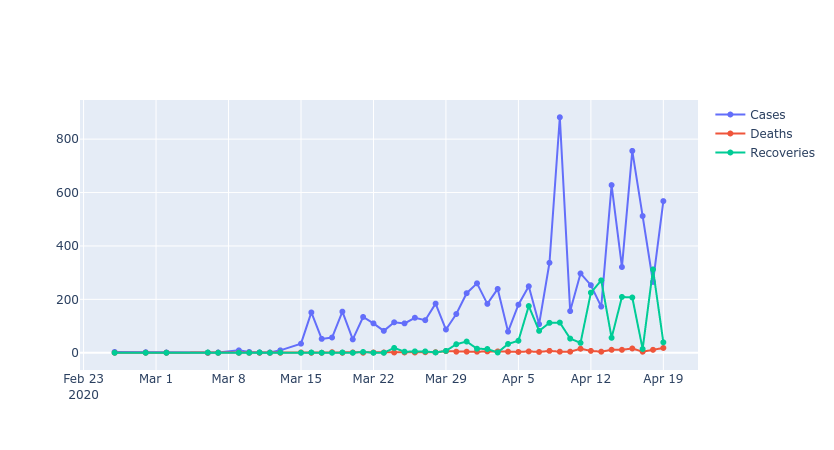

In [31]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=p['Date'], y=p['Cases'],
                    mode='lines+markers',
                    name='Cases'))
fig.add_trace(go.Scatter(x=p['Date'], y=p['Deaths'],
                    mode='lines+markers',
                    name='Deaths'))
fig.add_trace(go.Scatter(x=p['Date'], y=p['Recovered'],
                    mode='lines+markers',
                    name='Recoveries'))

fig.show()

### Cumulative Sums of Daily Cases vs Deaths vs Recoveries

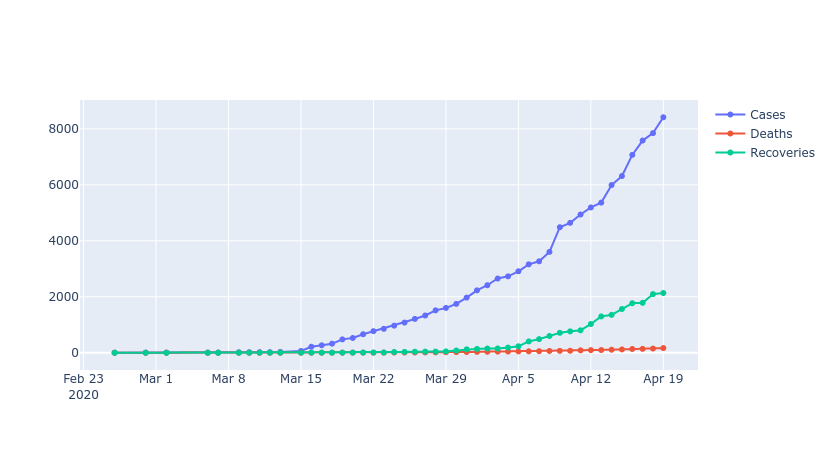

In [32]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=p['Date'], y=p['Cum_Cases'],
                    mode='lines+markers',
                    name='Cases'))
fig.add_trace(go.Scatter(x=p['Date'], y=p['Cum_Deaths'],
                    mode='lines+markers',
                    name='Deaths'))
fig.add_trace(go.Scatter(x=p['Date'], y=p['Cum_Recovered'],
                    mode='lines+markers',
                    name='Recoveries'))

fig.show()

### Scatter plot of cases with OLS trendline.

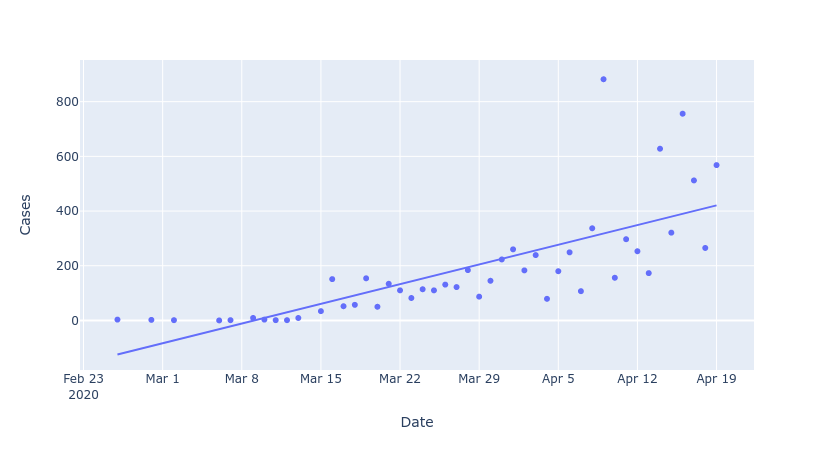

In [33]:
px.scatter(p, x= 'Date', y = 'Cases', trendline = "ols")

# **Setting up Environment in PyCaret**

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment.

In [34]:
# the data check
p.head()

,Date,Cases,Deaths,Recovered,Cum_Cases,Cum_Cases_next,Cum_Deaths,Cum_Recovered,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2020-02-26,3.0,0.0,0.0,3.0,5.0,0.0,0.0,26,2,9,2,1.0,1,57
1,2020-02-29,2.0,0.0,0.0,5.0,6.0,0.0,0.0,29,2,9,5,0.0,1,60
2,2020-03-02,1.0,0.0,0.0,6.0,6.0,0.0,0.0,2,3,10,0,1.0,1,62
3,2020-03-06,0.0,0.0,1.0,6.0,7.0,0.0,1.0,6,3,10,4,1.0,1,66
4,2020-03-07,1.0,0.0,0.0,7.0,16.0,0.0,1.0,7,3,10,5,0.0,1,67


In [35]:
p

,Date,Cases,Deaths,Recovered,Cum_Cases,Cum_Cases_next,Cum_Deaths,Cum_Recovered,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear
0,2020-02-26,3.0,0.0,0.0,3.0,5.0,0.0,0.0,26,2,9,2,1.0,1,57
1,2020-02-29,2.0,0.0,0.0,5.0,6.0,0.0,0.0,29,2,9,5,0.0,1,60
2,2020-03-02,1.0,0.0,0.0,6.0,6.0,0.0,0.0,2,3,10,0,1.0,1,62
3,2020-03-06,0.0,0.0,1.0,6.0,7.0,0.0,1.0,6,3,10,4,1.0,1,66
4,2020-03-07,1.0,0.0,0.0,7.0,16.0,0.0,1.0,7,3,10,5,0.0,1,67
5,2020-03-09,9.0,0.0,0.0,16.0,19.0,0.0,1.0,9,3,11,0,1.0,1,69
6,2020-03-10,3.0,0.0,0.0,19.0,20.0,0.0,1.0,10,3,11,1,1.0,1,70
7,2020-03-11,1.0,0.0,1.0,20.0,21.0,0.0,2.0,11,3,11,2,1.0,1,71
8,2020-03-12,1.0,0.0,0.0,21.0,30.0,0.0,2.0,12,3,11,3,1.0,1,72
9,2020-03-13,9.0,0.0,1.0,30.0,64.0,0.0,3.0,13,3,11,4,1.0,1,73


In [72]:
session_1 = setup(p, target = 'Cum_Cases_next', use_gpu=True,silent=True,remove_outliers=True,transform_target=True,ignore_features=['Cum_Cases','Dayofyear'],imputation_type='iterative')

,Description,Value
0,session_id,3966
1,Target,Cum_Cases_next
2,Original Data,"(46, 15)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(29, 23)"


# **Comparing All Models**
Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed 

In [73]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,374.3430,652396.0702,527.0278,0.8573,0.4876,7.7783,0.0120
gbr,Gradient Boosting Regressor,254.4433,134498.9803,329.1474,0.8564,0.3308,0.3657,0.0440
rf,Random Forest Regressor,307.4982,355098.5733,420.8356,0.8340,0.3048,0.3152,0.5370
ada,AdaBoost Regressor,333.1369,270077.6924,439.5141,0.7833,0.2959,0.2828,0.0760
et,Extra Trees Regressor,362.0053,343284.3288,458.7155,0.7777,0.4085,0.8430,0.5390
knn,K Neighbors Regressor,490.5394,532175.5916,634.7124,0.4861,0.5133,0.5571,0.0200
catboost,CatBoost Regressor,576.6850,1286052.9740,809.6379,0.4487,0.4537,0.7974,0.3950
dt,Decision Tree Regressor,350.3000,294667.1667,464.9677,0.1456,0.6998,1.1815,0.0120
omp,Orthogonal Matching Pursuit,804.5659,2240788.8599,1108.2297,0.1271,0.6420,2.3008,0.0150
ridge,Ridge Regression,629.6927,1704784.7320,869.0309,0.0081,0.4181,0.4221,0.0250


models() provide list of models in library and their id that can be used in functions

In [74]:
model_metadata = models()
model_metadata['Name'] # with ids

ID
lr                          Linear Regression
lasso                        Lasso Regression
ridge                        Ridge Regression
en                                Elastic Net
lar                    Least Angle Regression
llar             Lasso Least Angle Regression
omp               Orthogonal Matching Pursuit
br                             Bayesian Ridge
ard         Automatic Relevance Determination
par              Passive Aggressive Regressor
ransac                Random Sample Consensus
tr                         TheilSen Regressor
huber                         Huber Regressor
kr                               Kernel Ridge
svm                 Support Vector Regression
knn                     K Neighbors Regressor
dt                    Decision Tree Regressor
rf                    Random Forest Regressor
et                      Extra Trees Regressor
ada                        AdaBoost Regressor
gbr               Gradient Boosting Regressor
mlp                            

# **Create a Model**
The function that actually allows you to create a model is called `create_model()`

Model currently under consideration:

1. CatBoost Regressor('catboost')
2. Bayesian Ridge('br')
3. Random Forest('fr')

### CatBoost Regressor

In [75]:
catboost  = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,43.6389,2835.1108,53.2458,0.9957,0.5824,0.7384
1,1022.0423,1411215.5712,1187.9459,-1.7304,0.3106,0.2275
2,423.9077,296155.9064,544.2021,0.9715,1.5908,5.2728
3,203.6543,115587.9217,339.9822,0.9376,0.3910,0.4263
4,1647.8252,5637623.7918,2374.3681,0.4726,0.4264,0.3188
5,149.8244,31101.0837,176.3550,-0.4476,0.1494,0.1395
6,1299.4696,4857274.2650,2203.9225,0.5746,0.4404,0.2802
7,289.0312,94474.6660,307.3673,0.8041,0.1927,0.1750
8,344.5243,185525.9097,430.7272,0.9699,0.3418,0.3166
9,342.9316,228735.5138,478.2630,0.9389,0.1117,0.0790


### Bayesian Ridge

In [76]:
br  = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,614.9962,1037213.1675,1018.4366,-0.5658,0.9584,1.6659
1,1402.3026,2215018.9405,1488.2940,-3.2856,0.3488,0.3124
2,411.9946,386314.4907,621.5420,0.9628,0.4473,0.4815
3,128.5411,29407.3890,171.4858,0.9841,0.8719,1.3564
4,648.1696,599081.2774,774.0034,0.9440,0.2122,0.1946
5,326.5553,106869.1145,326.9084,-3.9742,0.3855,0.3167
6,1410.0464,5720321.3326,2391.7193,0.4991,0.2757,0.2729
7,646.2571,597446.3682,772.9465,-0.2389,0.4292,0.3372
8,210.5698,67641.8286,260.0804,0.9890,0.1353,0.1074
9,1619.2925,4490827.4401,2119.1572,-0.1994,0.4487,0.4851


### Random Forest

In [77]:
rf  = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,30.8126,1428.5347,37.7960,0.9978,0.4499,0.5160
1,535.4709,394052.7493,627.7362,0.2376,0.1771,0.1276
2,201.7720,68696.6784,262.1005,0.9934,0.8766,1.3346
3,54.9849,7220.0551,84.9709,0.9961,0.3479,0.3291
4,792.2771,1138512.2959,1067.0109,0.8935,0.1681,0.1419
5,71.1302,10893.6557,104.3727,0.4930,0.0935,0.0607
6,805.0744,1764523.5694,1328.3537,0.8455,0.5491,0.3135
7,205.7832,44711.7471,211.4515,0.9073,0.1370,0.1270
8,183.2653,80875.9321,284.3869,0.9869,0.0953,0.0809
9,194.4113,40070.5150,200.1762,0.9893,0.1536,0.1211


# **Tune a Model**
In order to tune hyperparameters, the tune_model() function is used.

### CatBoost Regressor

In [78]:
tuned_catboost = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.9835,9936.2815,99.6809,0.9850,0.3138,0.3038
1,742.8508,764376.0944,874.2860,-0.4789,0.2138,0.1644
2,205.0972,85904.8033,293.0952,0.9917,0.6098,0.7314
3,92.0765,21999.0668,148.3208,0.9881,0.2713,0.2971
4,1536.9673,4864765.0191,2205.6212,0.5449,0.3640,0.2483
5,137.0521,37354.3487,193.2727,-0.7387,0.1587,0.1304
6,724.4898,1497407.2144,1223.6859,0.8689,0.4133,0.2557
7,178.5716,70621.9377,265.7479,0.8536,0.0974,0.0808
8,168.4283,38325.0002,195.7677,0.9938,0.1159,0.1039
9,188.2633,70742.6552,265.9749,0.9811,0.0597,0.0408


### Bayesian Ridge

In [79]:
tuned_br = tune_model(br)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,59.7317,8127.6382,90.1534,0.9877,0.3877,0.4197
1,401.9150,180612.5108,424.9853,0.6506,0.0884,0.0869
2,717.4650,850238.9025,922.0840,0.9181,2.5752,30.2944
3,17.1334,397.4580,19.9363,0.9998,0.4288,0.2882
4,296.9042,201764.8312,449.1824,0.9811,0.0589,0.0550
5,155.3855,32398.4125,179.9956,-0.5080,0.2428,0.1642
6,293.3219,174455.7737,417.6790,0.9847,0.2943,0.1936
7,237.7319,80087.5378,282.9974,0.8339,0.1436,0.1285
8,496.7950,331013.1835,575.3375,0.9463,0.2912,0.2989
9,115.6721,13643.9741,116.8074,0.9964,0.1332,0.0961


### Random Forest

In [80]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,102.4001,22078.3015,148.5877,0.9667,0.7248,0.9329
1,877.0005,966534.5285,983.1249,-0.8700,0.2146,0.2034
2,179.8340,61308.6489,247.6058,0.9941,1.0686,1.9369
3,59.0147,6470.8415,80.4415,0.9965,0.5927,0.6729
4,544.4057,628015.7062,792.4744,0.9413,0.2416,0.1700
5,47.6699,4687.0965,68.4624,0.7818,0.0604,0.0447
6,324.8280,208134.3859,456.2175,0.9818,0.6344,0.2923
7,459.6099,244975.0627,494.9496,0.4920,0.7161,0.3418
8,418.2560,254543.4347,504.5230,0.9587,0.2137,0.2157
9,163.1879,27962.5671,167.2201,0.9925,0.1303,0.1036


# **Plotting a Model**

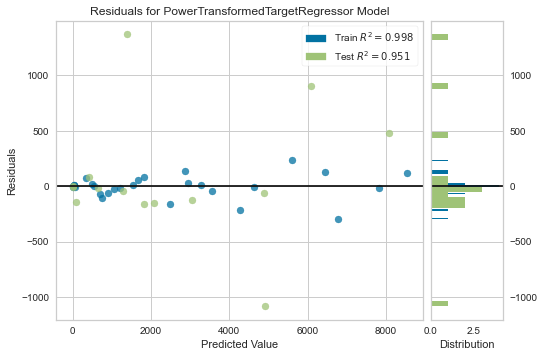

In [81]:
plot_model(tuned_br)

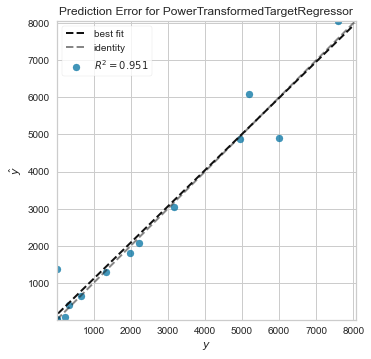

In [82]:
plot_model(tuned_br, plot = 'error')

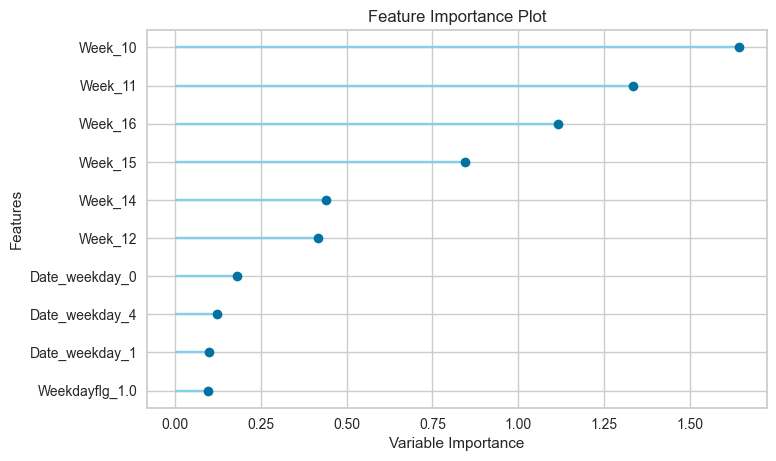

In [83]:
plot_model(tuned_br, plot='feature')

In [90]:
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# **Predict on test / hold-out Sample**

### Blend Model
This function can be used to blend specific trained models that can be passed using estimator_list parameter 

In [85]:
blend = blend_models(estimator_list = [tuned_catboost, tuned_br, tuned_rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,74.2923,12609.4202,112.2917,0.9810,0.4810,0.5214
1,423.8869,198080.3579,445.0622,0.6168,0.1181,0.1001
2,190.5880,46232.1277,215.0166,0.9955,1.6161,5.5006
3,13.6917,378.5230,19.4557,0.9998,0.1483,0.1278
4,651.7559,899230.5292,948.2777,0.9159,0.1489,0.1300
5,82.8734,8587.9989,92.6715,0.6003,0.1015,0.0855
6,421.6915,499180.3337,706.5270,0.9563,0.4338,0.2295
7,173.7680,45664.0131,213.6914,0.9053,0.2550,0.1447
8,249.8409,90552.4772,300.9194,0.9853,0.1924,0.1717
9,157.2073,29470.8093,171.6706,0.9921,0.0927,0.0815


### Predicting 
Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics

In [86]:
pred = predict_model(blend);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,184.6232,83270.6964,288.5666,0.9863,1.2491,7.8786


# **Finalize Model for Deployment**

- Model finalization is the last step in the experiment.
- The `finalize_model()` function fits the model onto the complete dataset including the test/hold-out sample.

In [87]:
final_blend = finalize_model(blend)

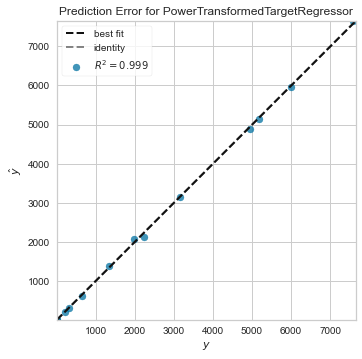

In [88]:
plot_model(final_blend, plot = 'error')

# **Saving the model**
`save_model()` allows you to save the model along with entire transformation pipeline for later use.

In [89]:
# TIP : It's always good to use date in the filename when saving models, it's good for version control.
save_model(final_blend,'Final Blend Model 03August2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Cum_Cases',
                                                        'Dayofyear'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Cum_Cases_next',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_...
                                                                                                               max_depth=10,
                                                       